In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import tensorflow.keras as keras 
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plts

from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/age_gender.csv')

ethnicity_mapping = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Hispanic"}
df['ethnicity'].replace(ethnicity_mapping, inplace=True)

tmp = pd.get_dummies(df['ethnicity'], prefix='eth')
df = pd.concat([df, tmp], axis=1)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,age,ethnicity,gender,img_name,pixels,eth_Asian,eth_Black,eth_Hispanic,eth_Indian,eth_White
0,1,Asian,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,1,0,0,0,0
1,1,Asian,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,1,0,0,0,0
2,1,Asian,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,1,0,0,0,0
3,1,Asian,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,1,0,0,0,0
4,1,Asian,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
23700,99,White,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...,0,0,0,0,1
23701,99,Black,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...,0,1,0,0,0
23702,99,Asian,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...,1,0,0,0,0
23703,99,Asian,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...,1,0,0,0,0


Unique age values:  104


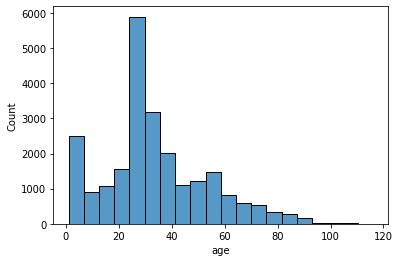

In [ ]:
print('Unique age values: ', df['age'].nunique())
sns.histplot(df['age'], bins=20)

In [ ]:
def convert_age(age_value):
    

    if age_value<=10:
        age_category = 0
    if 11<=age_value<=15:
        age_category = 1
    if 16<=age_value<=20:
        age_category = 2
    if 21<=age_value<=25:
        age_category = 3
    if 26<=age_value<=30:
        age_category = 4
    if 31<=age_value<=35:
        age_category = 5
    if 36<=age_value<=42:
        age_category = 6
    if 43<=age_value<=50:
        age_category = 7
    if 51<=age_value<=60:
        age_category = 8
    if age_value>60:
        age_category = 9
        
    return age_category

df['age_category'] = df['age'].apply(convert_age)
df

,age,ethnicity,gender,img_name,pixels,eth_Asian,eth_Black,eth_Hispanic,eth_Indian,eth_White,age_category
0,1,Asian,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,1,0,0,0,0,0
1,1,Asian,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,1,0,0,0,0,0
2,1,Asian,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,1,0,0,0,0,0
3,1,Asian,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,1,0,0,0,0,0
4,1,Asian,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
23700,99,White,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...,0,0,0,0,1,9
23701,99,Black,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...,0,1,0,0,0,9
23702,99,Asian,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...,1,0,0,0,0,9
23703,99,Asian,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...,1,0,0,0,0,9


In [ ]:
to_drop = df[df['age']<=3].index
len(to_drop)
dfx = df.drop(to_drop, axis=0)
dfx['age_category'].value_counts()

dfx = dfx.sample(frac=1).reset_index(drop=True)

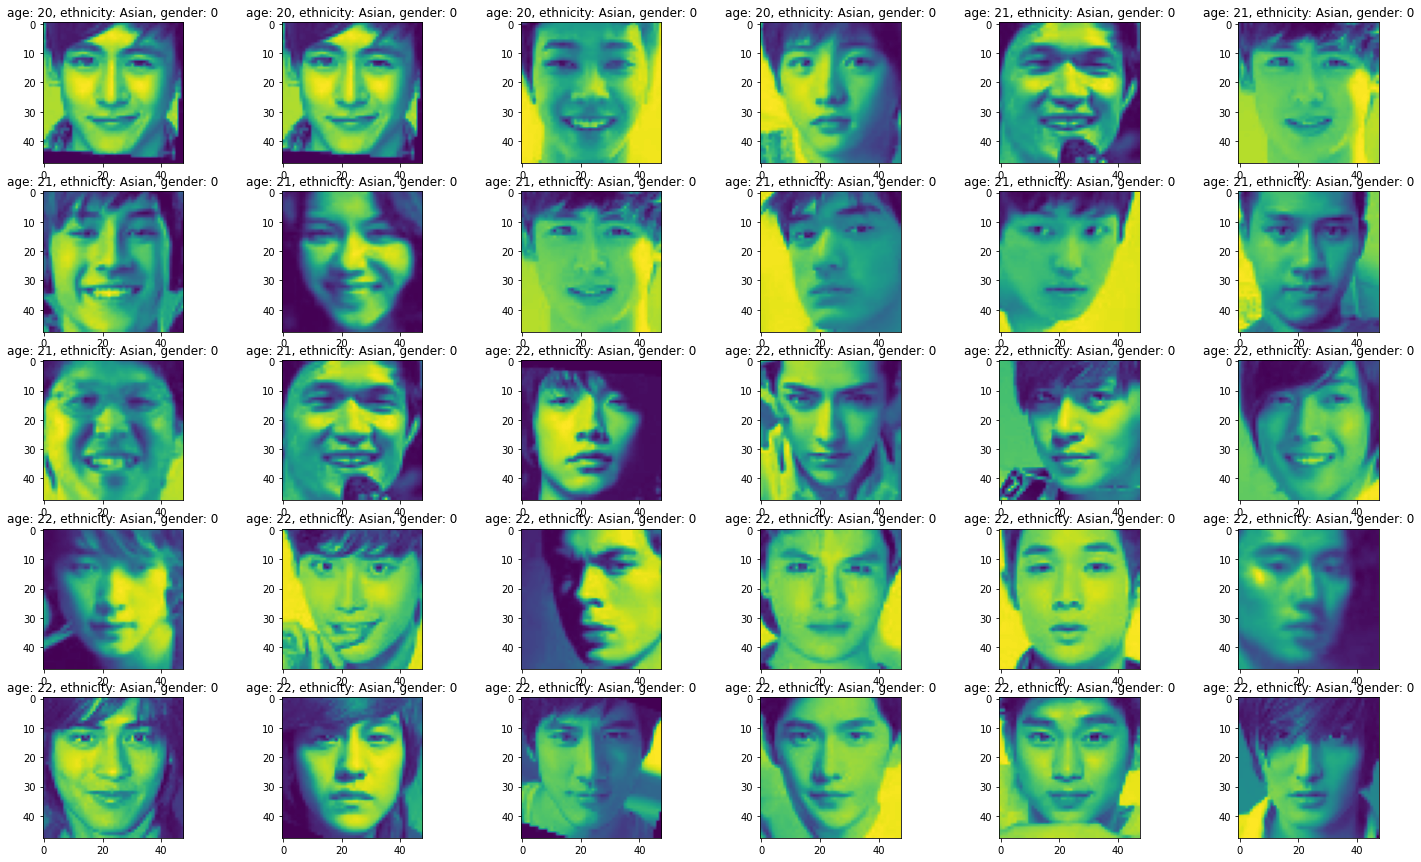

In [ ]:
eth = 'Asian'
age_min = 20
age_max = 50
gender = 0

fig = plt.figure(figsize=(25,15))

tmp = df[(df['ethnicity']==eth) & (df['age']>=age_min) & (df['age']<=age_max)& (df['gender']==gender)].index[:30]

j=0
for i in tmp:
    j+=1
    ax = fig.add_subplot(5,6,j)
    ax.imshow(np.array(df['pixels'][i].split(' '), dtype='int64').reshape(48,48))
    plt.title(f'age: {df.age[i]}, ethnicity: {df.ethnicity[i]}, gender: {df.gender[i]}')

In [ ]:
def create_inputs_targets(df):
    images = np.zeros((len(df), 48, 48))

    for i in tqdm(range(len(df))):
        images[i] = (np.array(df['pixels'][i].split(' '), dtype='int64').reshape(48,48)/255.0)
     
    age_labels = np.array(df['age_category'])
    gender_labels = np.array(df['gender'])
    ethnicity_labels = np.array(df[['eth_Asian', 'eth_Black', 'eth_Hispanic', 'eth_Indian', 'eth_White']])
    
    return images, [age_labels, gender_labels, ethnicity_labels]

In [ ]:
validation_data_indices = dfx.sample(frac=0.2).index
validation_df = df.loc[validation_data_indices, :].reset_index(drop=True)

train_df = dfx.drop(validation_data_indices, axis=0).reset_index(drop=True)

x_train, y_train = create_inputs_targets(train_df)
x_val, y_val = create_inputs_targets(validation_df)

print('Training data shape:', x_train.shape, y_train[0].shape, y_train[1].shape, y_train[2].shape)
print('Validation data shape:', x_val.shape, y_val[0].shape, y_val[1].shape, y_val[2].shape)

100%|██████████| 4362/4362 [00:01<00:00, 2235.03it/s]

Training data shape: (17449, 48, 48) (17449,) (17449,) (17449, 5)
Validation data shape: (4362, 48, 48) (4362,) (4362,) (4362, 5)


In [ ]:
class create_model():
    
    def __init__(self, im_width=48, im_height=48):
        
        self.im_height = im_height
        self.im_width = im_width
        
  
        self.base = keras.applications.DenseNet169(weights=None, include_top=False, input_shape=(self.im_height, self.im_width, 1))
        self.base.trainable=True
        self.base_output_layer = self.base.output

    
    def gender_branch(self):
        
        x = keras.layers.GlobalAveragePooling2D()(self.base_output_layer)
        x = keras.layers.Dense(128, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(32, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(1, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros())(x)
        
        x = keras.layers.Activation('sigmoid', name='gender_output')(x)
        
        return x    
   
    
    def age_branch(self): 
        
      
        x = keras.layers.GlobalAveragePooling2D()(self.base_output_layer)
        x = keras.layers.Dense(128, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(32, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(10, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros())(x)
        
        x = keras.layers.Activation('softmax', name='age_output')(x)
        
        return x
    
   
    def ethnicity_branch(self): 
        
       
        x = keras.layers.GlobalAveragePooling2D()(self.base_output_layer)
        x = keras.layers.Dense(128, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(32, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(5, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros())(x)
        
        x = keras.layers.Activation('softmax', name='ethnicity_output')(x)
        
        return x  
    
    def full_model(self):
       
        age_branch = self.age_branch()
        gender_branch = self.gender_branch()
        ethnicity_branch = self.ethnicity_branch() 
        
        model = keras.models.Model(inputs= self.base.input,
                     outputs = [age_branch, gender_branch, ethnicity_branch],
                     name="FACE_NET")        
        return model
    
m = create_model(im_width=48, im_height=48)
model = m.full_model()


In [ ]:
losses = {'age_output': keras.losses.SparseCategoricalCrossentropy(), 
          'gender_output': keras.losses.BinaryCrossentropy(),
          'ethnicity_output': keras.losses.CategoricalCrossentropy()}


loss_weights = {'age_output': 1.0, 
                'gender_output': 0.5,
                'ethnicity_output':0.5}

metrices = {'age_output': [keras.metrics.SparseTopKCategoricalAccuracy(k=1)], 
            'gender_output': [keras.metrics.BinaryAccuracy()],
            'ethnicity_output': [keras.metrics.CategoricalAccuracy()]}

init_lr = 1e-4
epochs = 8
model.compile(optimizer = keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs), 
              loss = losses,
              loss_weights = loss_weights,
              metrics=metrices)

my_callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=5, mode='min', restore_best_weights=True)]

hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=32, callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/8
546/546 [==============================] - 950s 2s/step - loss: 2.9078 - age_output_loss: 2.0212 - gender_output_loss: 0.5230 - ethnicity_output_loss: 1.2502 - age_output_sparse_top_k_categorical_accuracy: 0.2665 - gender_output_binary_accuracy: 0.7345 - ethnicity_output_categorical_accuracy: 0.5135 - val_loss: 3.3848 - val_age_output_loss: 2.2544 - val_gender_output_loss: 0.8682 - val_ethnicity_output_loss: 1.3925 - val_age_output_sparse_top_k_categorical_accuracy: 0.2231 - val_gender_output_binary_accuracy: 0.5569 - val_ethnicity_output_categorical_accuracy: 0.4454
Epoch 2/8
546/546 [==============================] - 925s 2s/step - loss: 2.4124 - age_output_loss: 1.7399 - gender_output_loss: 0.3531 - ethnicity_output_loss: 0.9919 - age_output_sparse_top_k_categorical_accuracy: 0.3490 - gender_output_binary_accuracy: 0.8455 - ethnicity_output_categorical_accuracy: 0.6349 - val_loss: 2.6352 - val_age_output_loss: 1.7801 - val_gender_output_loss: 0.6211 - val_ethnicity_output_

In [ ]:
predictions = model.predict(x_val)

In [ ]:
age_true = validation_df['age_category']
age_true = np.array(age_true)

age_pred = [np.argmax(predictions[0][i]) for i in range(len(x_val))]

age_map = {0:'<10', 1:'11-15', 2:'16-20', 3:'21-25', 4:'26-30', 5:'31-35', 6:'36-42', 7:'43-50', 8:'51-60', 9:'>60'}
reverse_age_map = {y:x for x,y in age_map.items()}

age_report = classification_report(age_true, age_pred, target_names=reverse_age_map.keys())
print(age_report)

              precision    recall  f1-score   support

         <10       0.86      0.93      0.90       538
       11-15       0.40      0.40      0.40       104
       16-20       0.32      0.57      0.41       217
       21-25       0.52      0.31      0.39       538
       26-30       0.52      0.72      0.60       976
       31-35       0.00      0.00      0.00       509
       36-42       0.39      0.47      0.43       483
       43-50       0.40      0.16      0.22       359
       51-60       0.45      0.60      0.51       445
         >60       0.49      0.78      0.60       193

    accuracy                           0.51      4362
   macro avg       0.43      0.49      0.45      4362
weighted avg       0.46      0.51      0.47      4362



In [ ]:
gender_true = validation_df['gender']
gender_true = np.array(gender_true)

gender_pred = [round(predictions[1][i][0]) for i in range(len(x_val))]

gender_report = classification_report(gender_true, gender_pred, target_names={'male':0, 'female':1}.keys())
print(gender_report)

              precision    recall  f1-score   support

        male       0.91      0.92      0.91      2275
      female       0.91      0.90      0.91      2087

    accuracy                           0.91      4362
   macro avg       0.91      0.91      0.91      4362
weighted avg       0.91      0.91      0.91      4362



In [ ]:
eth_true = validation_df[['eth_Asian','eth_Black','eth_Hispanic','eth_Indian','eth_White']].values
eth_true = [np.argmax(eth_true[i]) for i in range(len(eth_true))]

eth_pred = [np.argmax(predictions[2][i]) for i in range(len(x_val))]



eth_map = {0: 'Asian', 1: 'Black', 2: 'Hispanic', 3: 'Indian', 4: 'White'}
reverse_eth_map = {y:x for x,y in eth_map.items()}

eth_report = classification_report(eth_true, eth_pred, target_names=reverse_eth_map.keys())
print(eth_report)

              precision    recall  f1-score   support

       Asian       0.88      0.80      0.84       662
       Black       0.77      0.94      0.84       870
    Hispanic       0.48      0.13      0.20       317
      Indian       0.81      0.64      0.71       754
       White       0.78      0.89      0.83      1759

    accuracy                           0.79      4362
   macro avg       0.74      0.68      0.69      4362
weighted avg       0.78      0.79      0.77      4362



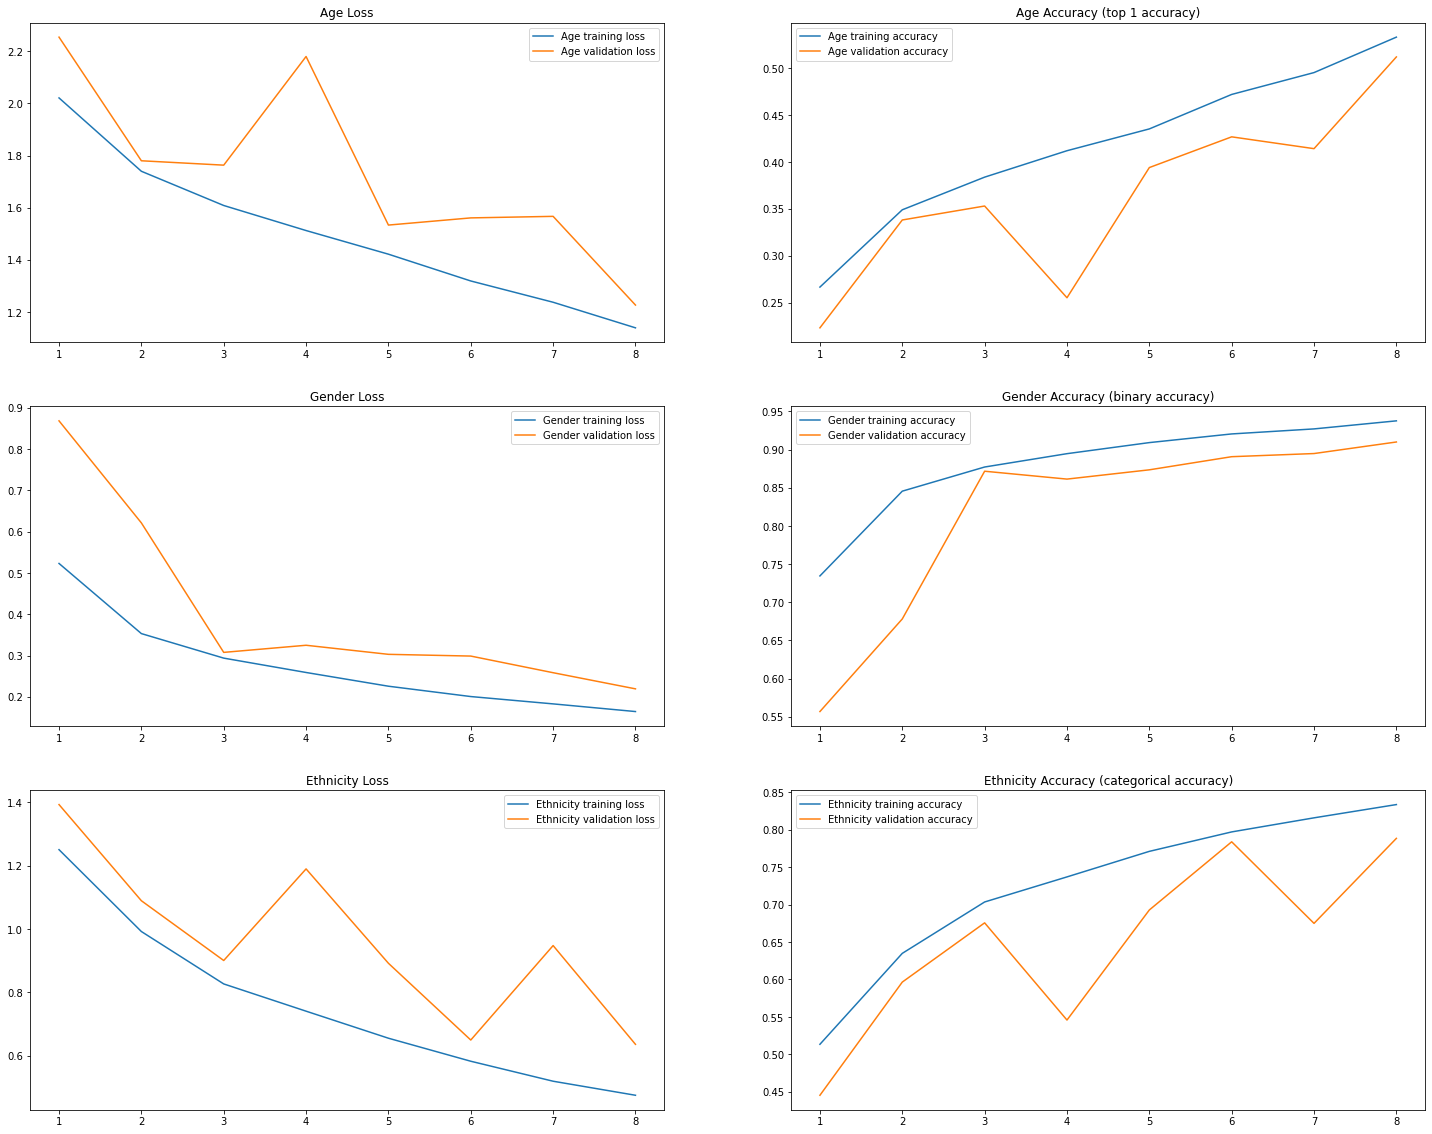

In [ ]:
fig = plt.figure(figsize=(25,20))
width = 2
height = 3

epochs = [i+1 for i in range(len(hist.history['loss']))]


ax = fig.add_subplot(height,width,1)
sns.lineplot(x = epochs, y = hist.history['age_output_loss'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_age_output_loss'], ax=ax)
plt.title('Age Loss')
plt.legend(['Age training loss', 'Age validation loss'])


ax = fig.add_subplot(height,width,2)
sns.lineplot(x = epochs, y = hist.history['age_output_sparse_top_k_categorical_accuracy'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_age_output_sparse_top_k_categorical_accuracy'], ax=ax)
plt.title('Age Accuracy (top 1 accuracy)')
plt.legend(['Age training accuracy', 'Age validation accuracy'])


ax = fig.add_subplot(height,width,3)
sns.lineplot(x = epochs, y = hist.history['gender_output_loss'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_gender_output_loss'], ax=ax)
plt.title('Gender Loss')
plt.legend(['Gender training loss', 'Gender validation loss'])


ax = fig.add_subplot(height,width,4)
sns.lineplot(x = epochs, y = hist.history['gender_output_binary_accuracy'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_gender_output_binary_accuracy'], ax=ax)
plt.title('Gender Accuracy (binary accuracy)')
plt.legend(['Gender training accuracy', 'Gender validation accuracy'])

ax = fig.add_subplot(height,width,5)
sns.lineplot(x = epochs, y = hist.history['ethnicity_output_loss'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_ethnicity_output_loss'], ax=ax)
plt.title('Ethnicity Loss')
plt.legend(['Ethnicity training loss', 'Ethnicity validation loss'])

ax = fig.add_subplot(height,width,6)
sns.lineplot(x = epochs, y = hist.history['ethnicity_output_categorical_accuracy'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_ethnicity_output_categorical_accuracy'], ax=ax)
plt.title('Ethnicity Accuracy (categorical accuracy)')
plt.legend(['Ethnicity training accuracy', 'Ethnicity validation accuracy'])

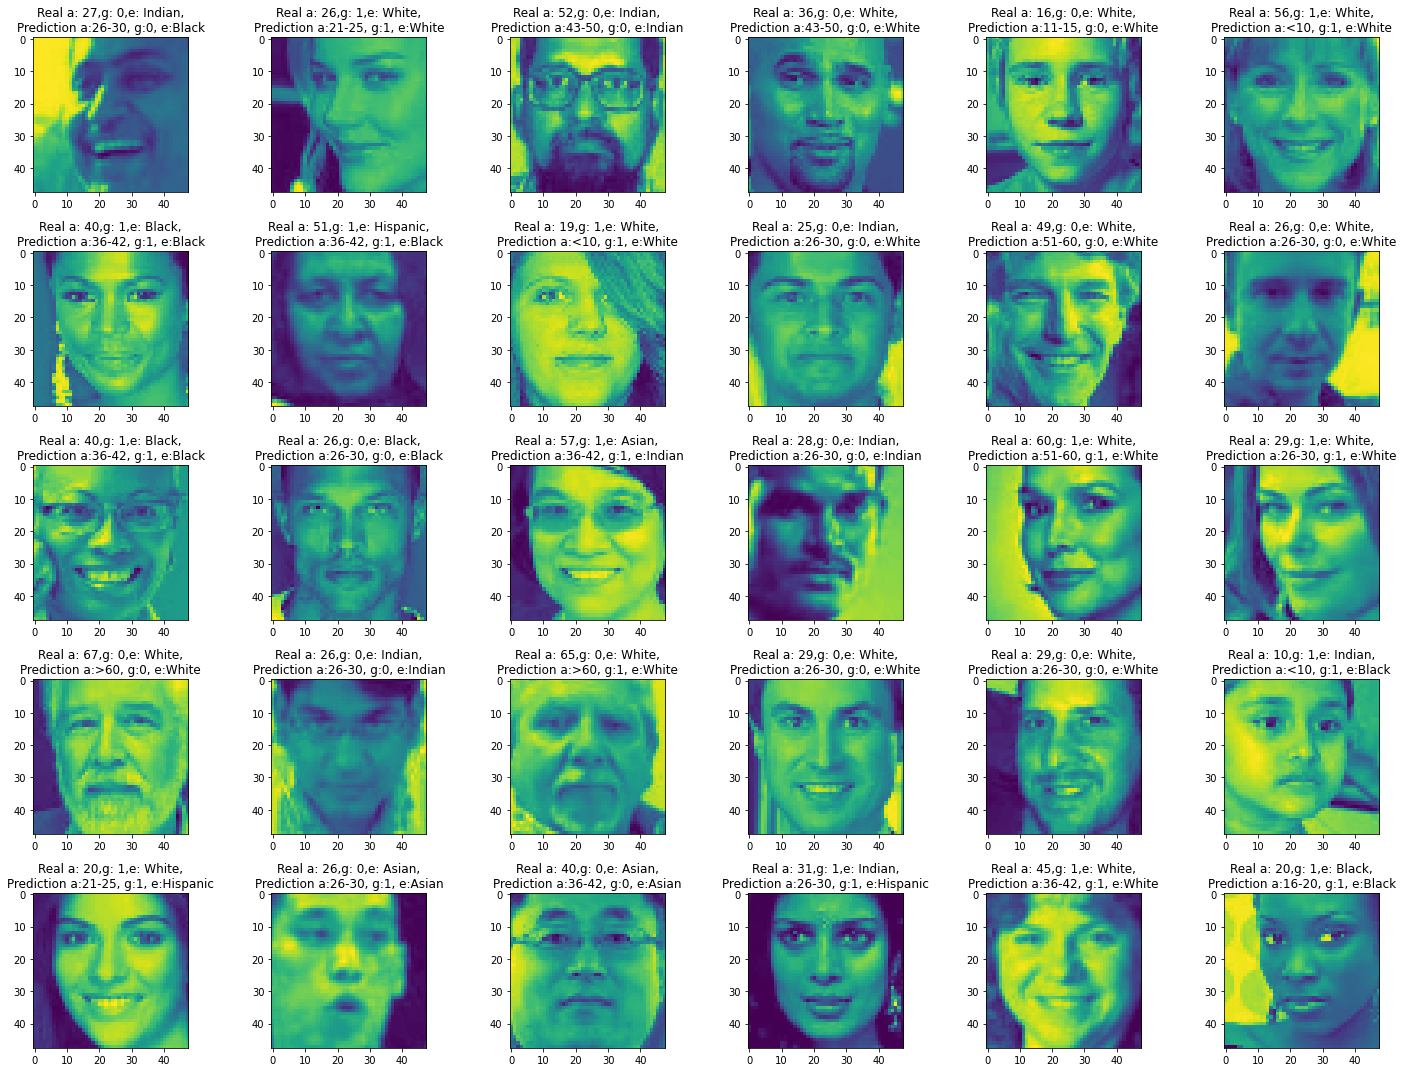

In [ ]:

random_indices = [np.random.randint(low=0, high=len(df)) for i in range(30)]

fig = plt.figure(figsize=(20,15))

for i in range(len(random_indices)):
    ax = fig.add_subplot(5,6,i+1)
    index = random_indices[i]
    img = df['pixels'][index]
    img = np.array(img.split(' '), dtype='int64').reshape(48,48)/255.0
    ax.imshow(img)
    
    output = model.predict(np.reshape(img, (1,48,48)))
    
    age, gender, eth = np.argmax(output[0]), round(output[1][0][0]), np.argmax(output[2])
    age = age_map[age]
    ethnicity = eth_map[eth]
    
    plt.title(f'Real a: {df.age[index]},g: {df.gender[index]},e: {df.ethnicity[index]},\nPrediction a:{age}, g:{gender}, e:{ethnicity}')
    
fig.tight_layout()